In [40]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline
# from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [41]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1688180207.494784
Sat Jul  1 02:56:47 2023


## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [42]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/gdrive/MyDrive/Colab Notebooks/data/44 Class 4478 Brain Tumor Images Split 0.627 Shuffle Rename'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=17,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



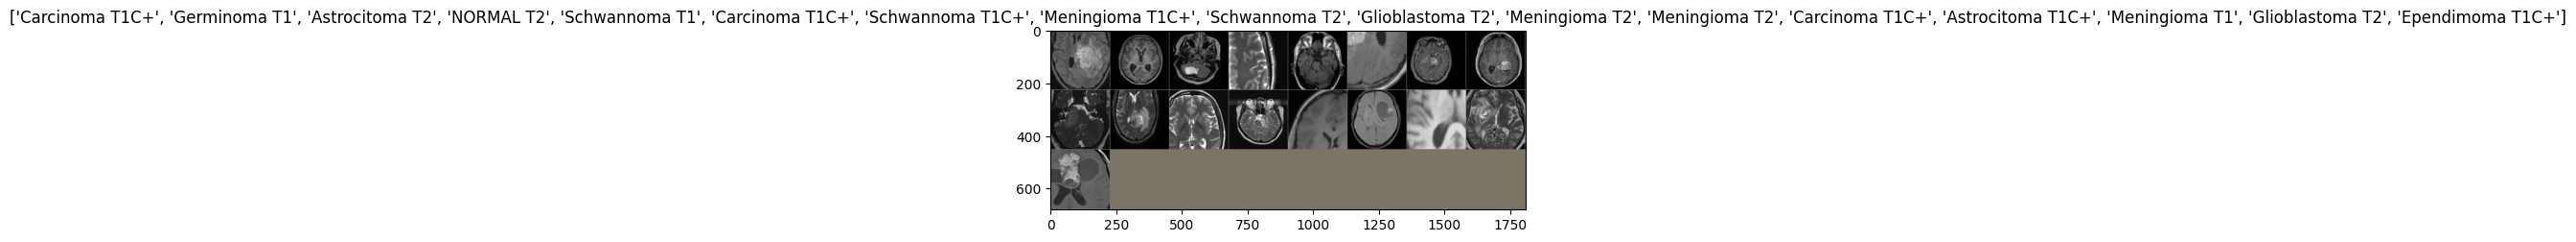

In [43]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [44]:
import time
import copy
from sklearn.metrics import confusion_matrix

def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_labels.extend(labels.data.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Calculate confusion matrix
            np.set_printoptions(threshold=44*44, linewidth=1000)
            cm = confusion_matrix(all_labels, all_preds)
            print(f'Confusion Matrix:\n{cm}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [46]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 44)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.93) #, weight_decay=0.01

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [47]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1688180209.156119
Sat Jul  1 02:56:49 2023


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [48]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 2.8423 Acc: 0.2686
Confusion Matrix:
[[ 15   6   0   1   4   0   2   0   0   5   0   0   0   0   0   0   1   0   0   0   0   0   0   0  19  11   2  33   1   1   1   0   1   0   0   0   0   0   2   2   3   0   0   0]
 [  7  37   0   0   2   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13  40   1  10   2   5   8   0   0   0   0   0   4   1   0  10   1   0   1   0]
 [  1   2  18   1   0   0   0   0   0   2   0   0   0   2   0   0   0   1   0   0   0   0   0   0   5   6  24   3  24   0   0   4   0   0   0   0   1   0   3   5   5   0   0   0]
 [  0   1   0  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   6   6   0  14   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   6   0   0  30   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   9  12   1   2   0   2   3   0   0   0   0   0   1   0   2   0   0   0   0   0]
 [  0   1   3   0   2   6   1   0 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 0.6025 Acc: 0.8351
Confusion Matrix:
[[ 94   1   0   0   0   0   3   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   4   0   0   1   0   1   0   0   2   0   0   3   0   0   0   0   0   0   0   0]
 [  2 129   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8   0   0   0   0   1   0   1   0   0   0   1   1   0   0   0   0   2   0]
 [  0   0  75   0   0   0   0   0   0   0   0   0   0   0   1   0   0   1   0   0   0   0   0   1   0   0  11   0   5   0   0   1   0   0   5   0   0   3   0   0   3   0   1   0]
 [  0   0   0  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   1   0   0  64   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   1   0   1  38   0   0   0   0   0   0   0   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.5218 Acc: 0.8468
Confusion Matrix:
[[ 60   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   2   0   0   2   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  1  77   0   0   0   0   0   3   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0  48   0   0   0   0   0   1   0   0   0   0   0   3   0   0   1   0   0   0   0   0   0   0   0   2   0   4   0   0   3   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0  21   0   0   0   0   0   0   0   0 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 0.5869 Acc: 0.8450
Confusion Matrix:
[[ 93   1   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   1   0   1   0   1   0   0   1   0   0   2   0   0   1   3   0   0   0   0]
 [  4 127   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   3   0   1   0   1   1   0   1   1   0   0   1   1   0   1   0   0   1   0]
 [  0   0  75   0   0   0   0   0   3   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0  12   1   6   0   0   1   0   0   0   0   0   1   3   0   3   0   0   0]
 [  0   0   0  35   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   4   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  67   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0  39   0   0   0   0   0   0   0   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.5187 Acc: 0.8492
Confusion Matrix:
[[ 61   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   2   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0  78   0   0   0   0   0   3   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0  50   0   0   0   0   0   1   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   1   0   4   0   0   4   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0  21   0   0   0   0   0   0   0   0 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 0.6121 Acc: 0.8326
Confusion Matrix:
[[ 99   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4   2   0   1   0   0   0   0   2   0   0   0   0   0   0   0   0   1   0   0]
 [  0 125   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   0   0   0   2   5   0   0   0   0   1   0   0   2   0   0   6   0   0   0   0   0   1   0]
 [  0   0  67   0   0   3   0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  11   0   9   0   0   2   0   0   1   0   1   3   0   0   4   0   1   0]
 [  0   0   0  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   0   0   0   1   1   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  1   1   0   0  64   0   0   0   0   0   0   0   1   0   0   0   1   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   1  40   0   0   0   0   0   0   0   

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4ff05e710>

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.5068 Acc: 0.8516
Confusion Matrix:
[[ 61   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   2   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0  79   0   0   0   0   0   2   0   0   0   0   0   3   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0  44   0   0   0   0   0   3   0   0   0   0   0   4   0   0   0   0   0   0   0   0   0   0   0   2   0   5   0   0   4   0   0   2   0   0   0   0   0   0   0   0   0]
 [  0   0   0  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0  34   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0  21   0   0   0   0   0   0   0   0 

In [49]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1688181301.1879928
Sat Jul  1 03:15:01 2023


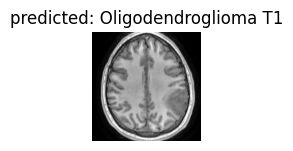

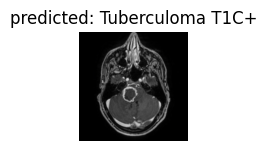

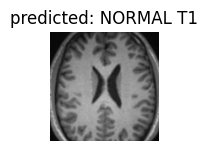

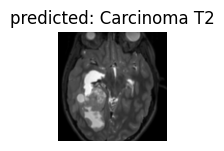

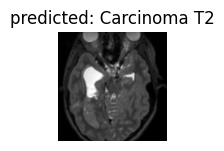

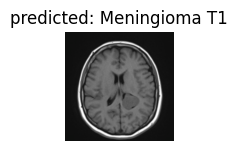

In [50]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [51]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 44)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.93, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [52]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 3.2579 Acc: 0.1649
Confusion Matrix:
[[  6   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  38  22   4  17   8   4   1   0   0   0   1   0   0   0   3   3   1   0   0   0]
 [  1  11   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23  53   5  19  10   1  10   0   0   0   0   0   0   1   1   5   0   0   4   0]
 [  1   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3  19  23   3  32   0   3   0   0   0   0   0   0   2   3  11   2   0   1   0]
 [  5   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   9  10   1  10   3   0   1   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   1   1   0   8   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  11  27   2   7   2   1   2   0   0   0   0   1   1   2   0   3   0   0   1   0]
 [  1   0   2   0   1   4   0   0 

In [53]:
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1688182355.8515925
Sat Jul  1 03:32:35 2023


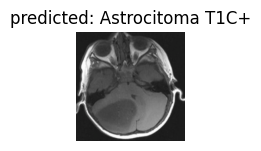

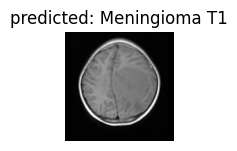

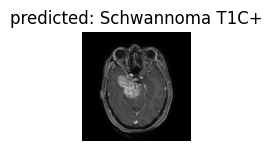

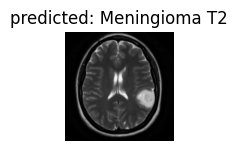

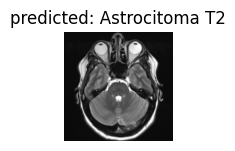

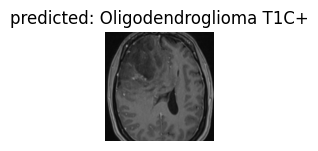

In [54]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



